Tổng diện tích lá cây: 21155.77 mm²


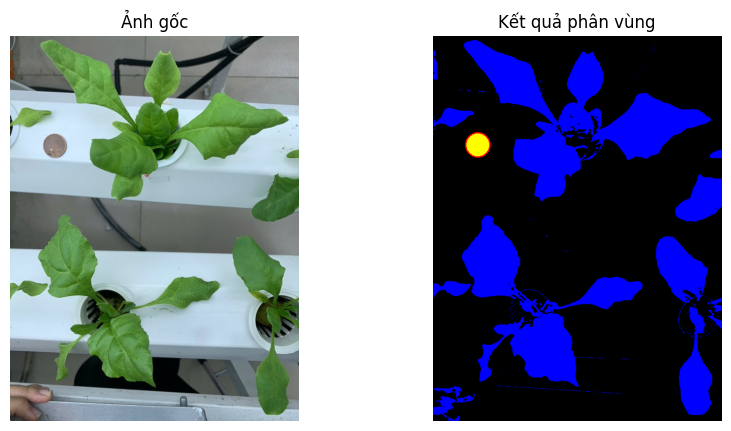

In [3]:
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
import matplotlib.pyplot as plt

def preprocess_image(image):
    """Tiền xử lý ảnh: chuyển sang HSV, làm mịn, và tạo ảnh thang xám."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    blurred = cv2.GaussianBlur(hsv, (5, 5), 0)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return blurred, gray

def detect_coins(gray_image):
    """Phát hiện đồng xu bằng Hough Circle Transform."""
    edges = cv2.Canny(gray_image, 50, 150)
    circles = cv2.HoughCircles(
        edges,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=50,
        param2=30,
        minRadius=10,
        maxRadius=60
    )
    return circles

def segment_image(hsv_image):
    """Phân cụm ảnh bằng Mean-Shift."""
    pixels = hsv_image.reshape(-1, 3).astype(np.float32)
    bandwidth = estimate_bandwidth(pixels, quantile=0.2, n_samples=500)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    labels = ms.fit_predict(pixels)
    segmented = labels.reshape(hsv_image.shape[:2])
    # print(np.unique(labels))
    # print(ms.cluster_centers_)
    # plt.imshow(segmented)
    return segmented, ms.cluster_centers_

def match_circles_to_segments(circles, segmented):
    """Ghép các vòng tròn với vùng phân cụm."""
    circle_regions = []
    if circles is not None:
        # print(segmented.shape[0], segmented.shape[1])
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            # print(x, y, r)  
            if 0 <= y < segmented.shape[0] and 0 <= x < segmented.shape[1]:
                region_label = segmented[y, x]
                circle_regions.append((x, y, r, region_label))
    return circle_regions

def select_coin_region(circle_regions, image, segmented):
    """Chọn vùng đồng xu dựa trên độ biến thiên màu, chỉ xét pixel trong hình tròn."""
    min_variance = float('inf')
    coin_label = None
    coin_circle = None
    
    image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)

    # Lấy kích thước ảnh
    height, width = segmented.shape
    i = 0
    for (x, y, r, region_label) in circle_regions:
        # Tạo mask hình tròn
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(mask, (int(x), int(y)), int(r), 255, -1)  # Vẽ hình tròn trắng

        # Lấy pixel trong vùng hình tròn từ image
        r1 = image[mask == 255]
        r2 = segmented[mask == 255]
        if len(r1) > 0 and len(r2) > 0:
            # Tính tổng độ lệch chuẩn của các kênh HSV
            v1 = np.std(r1, axis=0).sum()
            v2 = np.std(r2, axis=0).sum() * 100
            # print(f'C{i}:', v1, v2)
            # i += 1
            if v1 + v2 < min_variance:
                min_variance = v1 + v2
                coin_label = region_label
                coin_circle = (x, y, r)

    return coin_label, coin_circle

def calculate_scale_factor(coin_circle, coin_diameter_mm=21):
    """Tính tỷ lệ pixel/mm dựa trên đồng xu."""
    if coin_circle is None:
        raise ValueError("Không tìm thấy đồng xu.")
    _, _, radius_px = coin_circle
    scale_length = coin_diameter_mm / (2 * radius_px)
    scale_area = scale_length ** 2
    return scale_area

def identify_leaf_regions(segmented, hsv_image, coin_label):
    """Xác định vùng lá cây dựa trên màu xanh."""
    leaf_labels = []
    for label in np.unique(segmented):
        if label == coin_label:
            continue
        mask = (segmented == label).astype(np.uint8) * 255
        region_pixels = hsv_image[mask == 255]
        # plt.imshow(mask)
        # plt.show()
        if len(region_pixels) > 0:
            mean_hue = np.mean(region_pixels[:, 0])
            # print(mean_hue)
            if 50 <= mean_hue <= 60:
                leaf_labels.append(label)
    return leaf_labels

def calculate_total_leaf_area(segmented, leaf_labels, scale_area):
    """Tính tổng diện tích của tất cả vùng lá cây."""
    total_area_px = 0
    for label in leaf_labels:
        total_area_px += np.sum(segmented == label)
    total_area_mm2 = total_area_px * scale_area
    return total_area_mm2

def visualize_results(image, segmented, leaf_labels, coin_label, coin_circle):
    """Hiển thị kết quả phân vùng với màu khác nhau cho lá, đồng xu, và nền."""
    # Tạo ảnh kết quả với nền xám
    result = np.full_like(image, [0, 0, 0])  # Màu xám cho nền
    
    # Tô màu xanh cho vùng lá cây
    # print(len(leaf_labels))
    for label in leaf_labels:
        # label = leaf_labels[1]
        mask = (segmented == label).astype(np.uint8) * 255
        result[mask == 255] = [255, 0, 0]  # Màu xanh cho lá
    
    # Tô màu vàng cho vùng đồng xu (dựa trên hình tròn)
    if coin_circle is not None:
        x, y, r = coin_circle
        # Tạo mask hình tròn cho đồng xu
        height, width = image.shape[:2]
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(mask, (int(x), int(y)), int(r), 255, -1)  # Vẽ hình tròn trắng
        result[mask == 255] = [0, 255, 255]  # Màu vàng cho đồng xu
    
    # Vẽ viền đồng xu (tùy chọn để nổi bật hơn)
    if coin_circle is not None:
        x, y, r = coin_circle
        cv2.circle(result, (int(x), int(y)), int(r), (0, 0, 255), 2)  # Viền đỏ cho đồng xu
    
    return result

def combine_all(image_path):
    """Hàm chính để xử lý ảnh và tính tổng diện tích lá."""
    # Đọc ảnh
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Không thể đọc ảnh.")

    # Bước 1: Tiền xử lý
    hsv_image, gray_image = preprocess_image(image)

    # Bước 2: Phát hiện đồng xu
    circles = detect_coins(gray_image)

    # circles = np.uint16(np.around(circles))
    # for i in range(len(circles[0])):
    #     x, y, r = circles[0][i]
    #     # print(f"C{i}",x, y, r)
    #     # draw the outer circle
    #     cv2.circle(image,(x, y),r,(0, 100 * i, 0),2)
    #     # draw the center of the circle
    #     cv2.circle(image,(x, y),2,(0,0,255),3)
    #     cv2.putText(image, f"C{i}", (x - 10, y -10), cv2.FONT_HERSHEY_SIMPLEX, 
    #                         0.6, (255, 255, 0), 2)  # Vẽ text sau cùng
    # plt.imshow(image)

    # Bước 3: Phân cụm ảnh bằng Mean-Shift
    segmented, cluster_centers = segment_image(hsv_image)
    # cluster_centers = np.uint16(np.around(cluster_centers))
    # im_cp = image.copy()
    # for center in cluster_centers:
    #     cv2.circle(im_cp, (center[0], center[1]), 2, (0, 0, 0), 2)
    # plt.imshow(im_cp)

    # # Bước 4: Ghép vòng tròn với vùng
    circle_regions = match_circles_to_segments(circles, segmented)

    # # Bước 5: Chọn vùng đồng xu
    coin_label, coin_circle = select_coin_region(circle_regions, image, segmented)

    # # draw the outer circle
    # cv2.circle(image,(coin_circle[0],coin_circle[1]),coin_circle[2],(0, 255, 0),2)
    # # draw the center of the circle
    # cv2.circle(image,(coin_circle[0],coin_circle[1]),2,(0,0,255),3)
    # plt.imshow(image)

    # # Bước 6: Tính tỷ lệ
    scale_area = calculate_scale_factor(coin_circle)

    # # Bước 7: Xác định vùng lá
    leaf_labels = identify_leaf_regions(segmented, hsv_image, coin_label)
    # print(leaf_labels)
    # Bước 8: Tính tổng diện tích lá
    total_leaf_area = calculate_total_leaf_area(segmented, leaf_labels, scale_area)

    # Bước 9: Hiển thị kết quả
    result_image = visualize_results(image, segmented, leaf_labels, coin_label, coin_circle)

    # In kết quả
    print(f"Tổng diện tích lá cây: {total_leaf_area:.2f} mm²")

    # Lưu và hiển thị ảnh kết quả
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Ảnh gốc")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Kết quả phân vùng")
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    # Thay 'leaf_image.jpg' bằng đường dẫn đến ảnh của bạn
    image_paths = [
        "im.jpg",
        # 'datasets/X2/1_X2_1_1_211_10022025.jpg',
        # 'datasets/X2/3.x2.3.6.356.16022025.jpg',
        # 'datasets/X2/3.x2.3.5.166.07012025.jpg',
        # 'datasets/X2/3.X2.3.6.356.22022025.jpg',
        # 'datasets/X2/3.X2.3.7.168.16012025.jpg',
        # 'datasets/X2/3.X2.3.2.352.20022025.jpg',
        # 'datasets/X2/3.x2.3.3.353.16022025.jpg',
        # 'datasets/X2/3.X2.3.7.357.26022025.jpg',
        # 'datasets/Xb/1.Xb.1.1.43.16012025.jpg',
        # 'datasets/Xb/3.xb.3.7.189.07012025.jpg',
        # 'datasets/Xb/3.Xb.3.6.188.13012025.jpg',
    ]
    for image_path in image_paths:
        combine_all(image_path)